# 加载必要库

In [1]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import StandardScaler
from data.loaders import *
from methods.DomainAda import CORAL
from utils.PLOT import PCA_plot

loaders.py load successfully!


## 加载数据

In [16]:
dataset = 'drug'

In [18]:
if dataset == 'number':
    mat_number = load_number()
    data = mat_number.data
    label = mat_number.target
    sample_domain = np.array([1]*2000 +[0]*1800)

elif dataset == 'drug':
    mat_bulk = load_bulk_drug_response() 
    mat_sc = load_sc_drug_response()
    con_genes = list(set(mat_bulk.data.columns).intersection(mat_sc.data.columns))
    data = np.concatenate((mat_bulk.data.loc[:,con_genes], mat_sc.data.loc[:,con_genes]), axis=0)
    label = np.concatenate((mat_bulk.target, mat_sc.target), axis=0)
    sample_domain = np.array([1]*mat_bulk.data.shape[0] +[0]*mat_sc.data.shape[0])
    
else:
    mat_amazon = load_amazon_fc6()
    mat_dslr = load_dslr_fc6()
    data = np.concatenate((mat_amazon.data, mat_dslr.data), axis=0)
    label = np.concatenate((mat_amazon.target, mat_dslr.target), axis=0)
    sample_domain = np.array([1]*mat_amazon.data.shape[0] +[0]*mat_dslr.data.shape[0])

In [19]:
X = data
y = label

## 归一化到相同尺度

In [20]:
scaler = StandardScaler()
scaler.fit(X)
X[sample_domain == 1] = scaler.fit_transform(X[sample_domain == 1])
X[sample_domain == 0] = scaler.transform(X[sample_domain == 0])

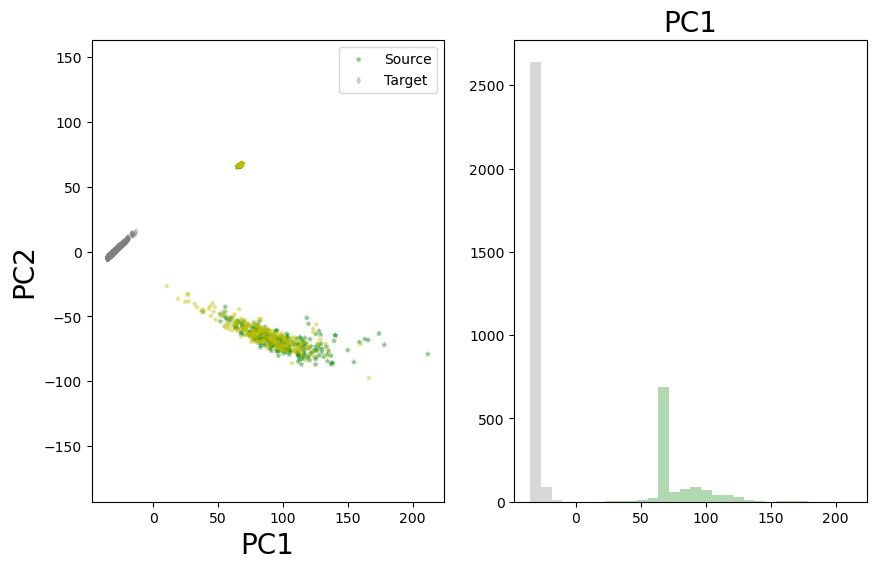

In [21]:
# 提取两个类别的数据进行可视化
sub_idx = np.where((label == 0) | (label == 1))
PCA_plot(X[sub_idx], y[sub_idx], sample_domain[sub_idx], 1, [0,1])

## 域适应对齐

In [25]:
coral = CORAL(0.01)
Xs_ada = coral.fit_transform(X,sample_domain) 
print( Xs_ada)

[[ 0.00813315 -0.00679361 -0.02883293 ...  0.00889854  0.00898362
  -0.05945196]
 [-0.01281687  0.00751464  0.06858884 ...  0.00739157  0.00956749
  -0.03088881]
 [-0.00635361  0.01445469  0.02493958 ...  0.03052282 -0.00450078
   0.07253995]
 ...
 [-0.04961719 -0.00136649 -0.01896743 ...  0.012697    0.02296553
   0.00376087]
 [-0.03360654  0.00428827  0.01439643 ... -0.02443794 -0.00271709
   0.0141154 ]
 [ 0.01000348 -0.07041155 -0.01109721 ... -0.00292081  0.01817119
  -0.00530194]]


In [31]:
print(Xs_ada.mean(),X[sample_domain == 1].mean(),X[sample_domain == 0].mean())
print(Xs_ada.var(),X[sample_domain == 1].var(),X[sample_domain == 0].var())

4.891252595386368e-16 -7.33372443032368e-16 -0.9862278066722322
0.008304791577007174 0.999999999999999 0.23831346961257266


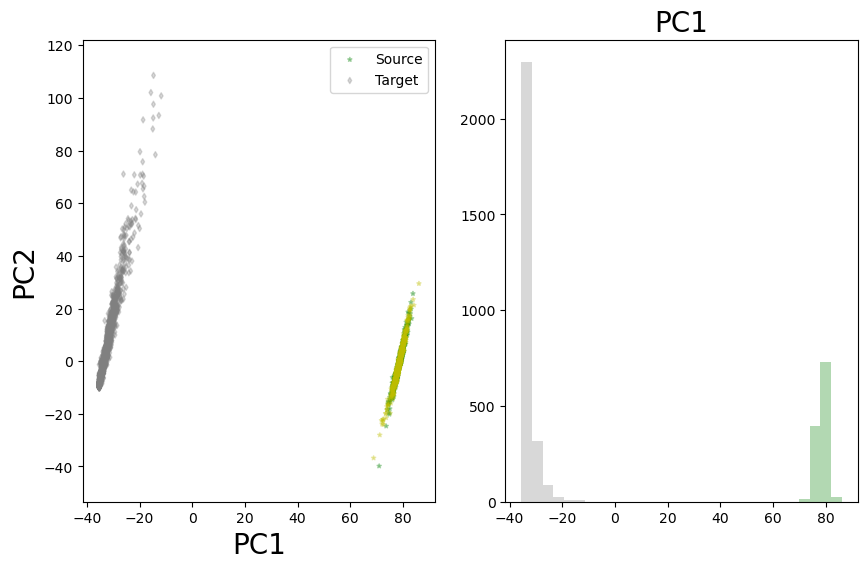

In [27]:
X_ada = np.concatenate((Xs_ada, X[sample_domain==0]), axis=0)
PCA_plot(X_ada[sub_idx], y[sub_idx], sample_domain[sub_idx], 1, [0,1])

# 训练
## 训练分类器

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def param_search(model,param_grid,X,y,test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,                # 5 折交叉验证
        scoring='roc_auc_ovr',  # 评价指标
        n_jobs=-1            # 并行加速
    )

    grid_search.fit(X_train, y_train)
    print("最佳参数组合：", grid_search.best_params_)
    print("训练集最佳得分：", grid_search.best_score_)
    print("测试集得分：", grid_search.best_estimator_.score(X_test, y_test))
        
    return grid_search.best_params_

In [33]:
from sklearn.svm import SVC
SVM = SVC(kernel='rbf', probability=True, random_state=42)
param_grid = {
    'C': np.logspace(-5,4,10) ,
    'gamma':np.logspace(-5,4,10) ,
}

opt_params = param_search(SVM,param_grid,X[sample_domain == 1],y[sample_domain == 1],0.3)

最佳参数组合： {'C': np.float64(10.0), 'gamma': np.float64(1e-05)}
训练集最佳得分： 0.7979981760145919
测试集得分： 0.6857142857142857


In [34]:
opt_params = param_search(SVM,param_grid,X_ada[sample_domain == 1],y[sample_domain == 1],0.3)
SVM = SVC(kernel='rbf', C=opt_params['C'], gamma=opt_params['gamma'], probability=True, random_state=42)

KeyboardInterrupt: 

## 预测目标域

In [ ]:
SVM.fit(X_ada[sample_domain == 1],y=y[sample_domain == 1])
y_prob = SVM.predict_proba(X_ada[sample_domain == 0])

In [ ]:
import sys
sys.path.append('/home/kazundo/WorkSpace/')
from MyModule.Mystatic import get_benchmark

get_benchmark(y[sample_domain == 0], y_prob)